In [1]:
import h2o
from h2o.automl import H2OAutoML

# Start the H2O cluster (locally)
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O_cluster_uptime:,5 hours 0 mins
H2O_cluster_timezone:,Europe/Kiev
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.44.0.3
H2O_cluster_version_age:,1 month and 23 days
H2O_cluster_name:,H2O_from_python_38066_vv52iw
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.011 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


EVALUATION

In [2]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from math import sqrt

def calculate_metrics(true_values, pred_values):
    mse = round(mean_squared_error(true_values, pred_values),3)
    mae = round(mean_absolute_error(true_values, pred_values),3)
    r_score = round(r2_score(true_values, pred_values),3)

    return {"mse": mse,
            "mae": mae,
            "r_score": r_score,}


In [17]:
import os
import sys
sys.path.insert(0, os.path.dirname('C:\work\DrugDiscovery\main_git\XAI_Chem\ml_part'))

import pandas as pd

from ml_part.random_forest.data_prep.preparation import DataPreparation
from ml_part.random_forest.train import RFTrain

CSV_PATH = r'C:\work\DrugDiscovery\main_git\XAI_Chem\data\updated_features\remained_features_pKa_08.02_v4_fixed_distances_chirality.csv'
smiles_filepath = r'C:\work\DrugDiscovery\main_git\XAI_Chem\data\updated_features\smiles_to_index.pkl'

dataPreparation = DataPreparation(CSV_PATH)

unimportant_features_to_drop = ['dipole_moment']
X, y = dataPreparation.prepare_data_for_RF(is_pKa=True,
                                           molecule_type="acid",
                                           use_mandatory_features=True,
                                           is_remove_outliers=True,
                                           is_remove_nan=True,
                                           outliers_features_to_skip=unimportant_features_to_drop)

correlated_features = ['f_atom_fraction', 'naHRing', 'nFaRing', 'nFaHRing', 'tpsa+f']
ring_features_to_remain = ['nFRing', 'nHRing', 'nARing', 'nFHRing']
features_to_drop = []
for feature_name in X.columns:
    if feature_name in correlated_features:
        features_to_drop.append(feature_name)
    elif "ring" in feature_name.lower() and feature_name not in ring_features_to_remain:
        features_to_drop.append(feature_name)
    elif len(X[feature_name].unique()) == 1:
        print(f"feature without unique values: {feature_name}")
        features_to_drop.append(feature_name)
    elif "angle" in feature_name or "distance" in feature_name:
        features_to_drop.append(feature_name)

X = X.drop(features_to_drop, axis=1)

rf_train = RFTrain(X=X, 
                   y=y,
                   smiles_filepath=smiles_filepath,
                   is_pKa=True,
                   k_folds=2)

y_train = rf_train.y_train
X_train = rf_train.X_train

y_test = rf_train.y_test
X_test = rf_train.X_test

train_df = pd.concat([X_train, y_train], axis=1)
test_df = pd.concat([X_test, y_test], axis=1)

print(len(train_df), len(test_df))

train = h2o.H2OFrame(train_df)
test = h2o.H2OFrame(test_df)

True
55
['RPCS', 'PBF', 'mol_weight', 'dipole_moment', 'PPSA5', 'avg_atoms_in_cycle', 'nHRing', 'cis/trans', 'f_atom_fraction', 'dihedral_angle', 'FPSA3', 'distance_between_atoms_in_cycle_and_f_group', 'angle_X1X2R2', 'nF', 'angle_R1X1R2', 'nFAHRing', 'nAHRing', 'chirality', 'sasa', 'PNSA5', 'GeomShapeIndex', 'TASA', 'angle_R2X2R1', 'mol_num_cycles', 'naRing', 'nN', 'f_freedom', 'tpsa+f', 'nFRing', 'identificator', 'nO', 'distance_between_atoms_in_f_group_centers', 'angle_X2X1R1', 'nARing', 'nFARing', 'nC', 'nFHRing', 'f_to_fg', 'pKa', 'logP']
RPCS outliers indexes: [9, 10, 11, 37, 41, 44, 45]
PBF outliers indexes: [40]
PPSA5 outliers indexes: [39, 40]
FPSA3 outliers indexes: [40]
GeomShapeIndex outliers indexes: [50]
logP outliers indexes: [48]
Remains rows:26, amount of features: 40
feature without unique values: nN
feature without unique values: identificator
21 5
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████

In [18]:
model_path = r'C:\\work\\DrugDiscovery\\main_git\\XAI_Chem\\ml_part\\h2o_model\\models\\08.02.24_feature_2.2\\pKa\\acid_molecules(without_angle_feature)_without_outliers\\DeepLearning_grid_2_AutoML_4_20240213_102321_model_43'

test_model = h2o.load_model(model_path)

In [19]:
test_model

Model Details
=============
H2ODeepLearningEstimator : Deep Learning
Model Key: DeepLearning_grid_2_AutoML_4_20240213_102321_model_43


Status of Neuron Layers: predicting pKa, regression, gaussian distribution, Quadratic loss, 3 801 weights/biases, 51,8 KB, 420 000 training samples, mini-batch size 1
    layer    units    type              dropout    l1    l2    mean_rate              rate_rms               momentum    mean_weight            weight_rms           mean_bias            bias_rms
--  -------  -------  ----------------  ---------  ----  ----  ---------------------  ---------------------  ----------  ---------------------  -------------------  -------------------  -----------------------
    1        23       Input             5.0
    2        50       RectifierDropout  0.0        0.0   0.0   0.024496835834984465   0.028362035751342773   0.0         0.009080568408952905   0.1712004542350769   0.39982008324941626  0.11887845396995544
    3        50       RectifierDropout  0.0        0.0   0.0   0.04334879989712499    0.10095798969268799    0.0         -0.019249103014224965  0.1569843888282776   0.9595998296748547   0.06979697942733765
    4        1        Linear                       0.0   0.0   0.0026043409283738584  0.0021110298112034798  0.0         -0.033043885827064516  0.19255274534225464  0.017726843065982    1.0971281125650402e-154

ModelMetricsRegression: deeplearning
** Reported on train data. **

MSE: 0.00025656668032468337
RMSE: 0.016017698970972185
MAE: 0.013271476996735814
RMSLE: 0.003207047749307793
Mean Residual Deviance: 0.00025656668032468337

ModelMetricsRegression: deeplearning
** Reported on cross-validation data. **

MSE: 0.053193099436878756
RMSE: 0.230636292540612
MAE: 0.16558666619175613
RMSLE: 0.04746416029523077
Mean Residual Deviance: 0.053193099436878756

Cross-Validation Metrics Summary: 
                        mean       sd         cv_1_valid    cv_2_valid
----------------------  ---------  ---------  ------------  ------------
mae                     0.165587   0.0202322  0.179893      0.15128
mean_residual_deviance  0.0531931  0.0218786  0.0686636     0.0377226
mse                     0.0531931  0.0218786  0.0686636     0.0377226
r2                      0.778083   0.0678938  0.730075      0.826091
residual_deviance       0.0531931  0.0218786  0.0686636     0.0377226
rmse                    0.22813    0.0479519  0.262037      0.194223
rmsle                   0.0467965  0.0112187  0.0547294     0.0388637

Scoring History: 
    timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_deviance    training_mae    training_r2
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  -------------------  --------------  -------------
    2024-02-13 10:38:45  0.000 sec                           0         0             0          nan              nan                  nan             nan
    2024-02-13 10:38:45  6 min 53.310 sec  52500 obs/sec     10        1             420        0.272146         0.0740633            0.223374        0.685759
    2024-02-13 10:38:50  6 min 58.314 sec  74512 obs/sec     8890      889           373380     0.0143612        0.000206243          0.0117991       0.999125
    2024-02-13 10:38:50  6 min 58.856 sec  75648 obs/sec     10000     1000          420000     0.0160177        0.000256567          0.0132715       0.998911

Variable Importances: 
variable            relative_importance    scaled_importance    percentage
------------------  ---------------------  -------------------  --------------------
f_to_fg             1.0                    1.0                  0.05559172507431036
PPSA5               0.9683301448822021     0.9683301448822021   0.053831143195458495
avg_atoms_in_cycle  0.9368228912353516     0.9368228912353516   0.05207960061287622
chirality           0.9122418761253357     0.9122418761253357   0.05071309957883274
PNSA5      

**OOS:**

In [20]:
preds = test_model.predict(test)
true = test.as_data_frame()['pKa']
predicted_values = preds.as_data_frame()['predict']

calculate_metrics(true, predicted_values)

deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%


c:\work\DrugDiscovery\drug-discovery-venv\Lib\site-packages\h2o\frame.py:1979: H2ODependencyWarning: converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above).
  warnings.warn("converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
c:\work\DrugDiscovery\drug-discovery-venv\Lib\site-packages\h2o\frame.py:1979: H2ODependencyWarning: converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above).
  warnings.warn("converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


{'mse': 0.013, 'mae': 0.099, 'r_score': 0.87}

c:\work\DrugDiscovery\drug-discovery-venv\Lib\site-packages\h2o\frame.py:1979: H2ODependencyWarning: converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above).
  warnings.warn("converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
C:\Users\38066\AppData\Local\Temp\ipykernel_10248\3135921164.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.barh(sum_rows.keys()[sorted_idx][::-1][:30][::-1], sum_rows[sorted_idx][::-1][:30][::-1])


Text(0.5, 0, 'H2O Feature Importance')

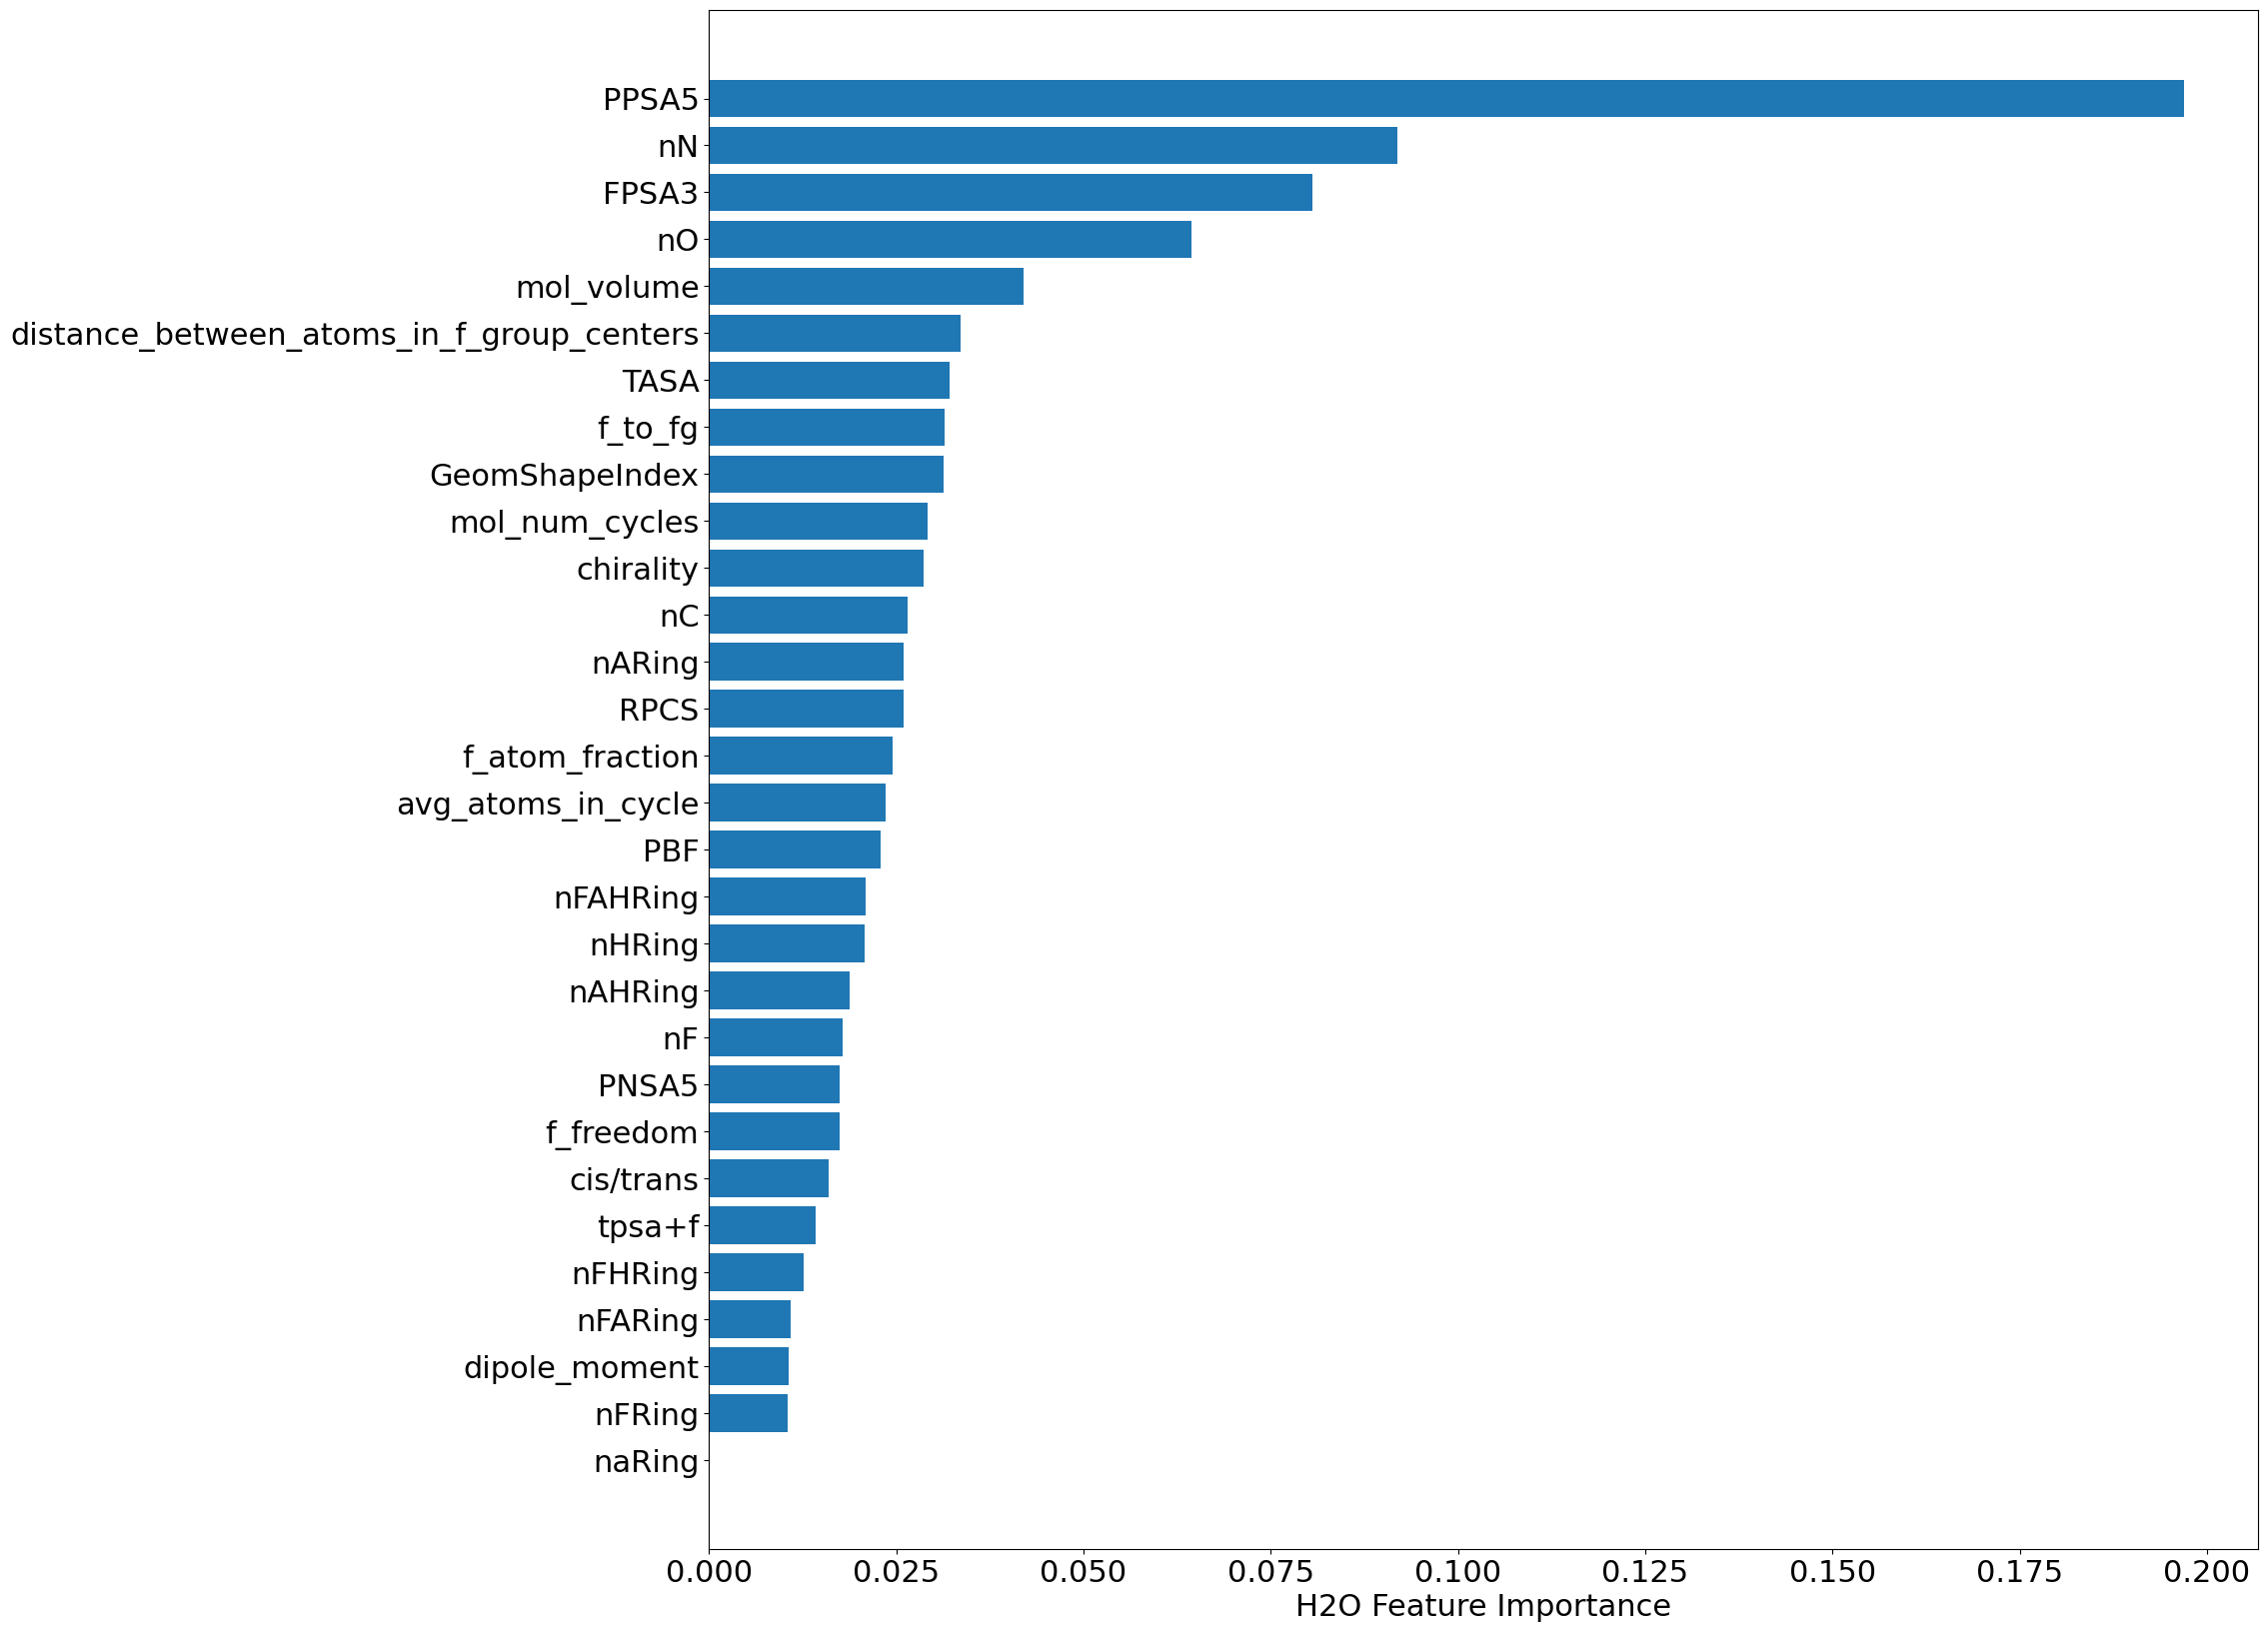

In [33]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 22})

# best_model = aml.get_best_model()
permutation_varimp = test_model.permutation_importance(train, use_pandas=True, n_repeats=500)

sum_rows = permutation_varimp.sum(axis=1)
sum_rows = sum_rows / sum(sum_rows)

sorted_idx = sum_rows.argsort()
plt.figure(figsize=(20,20))
plt.barh(sum_rows.keys()[sorted_idx][::-1][:30][::-1], sum_rows[sorted_idx][::-1][:30][::-1])
plt.xlabel("H2O Feature Importance")

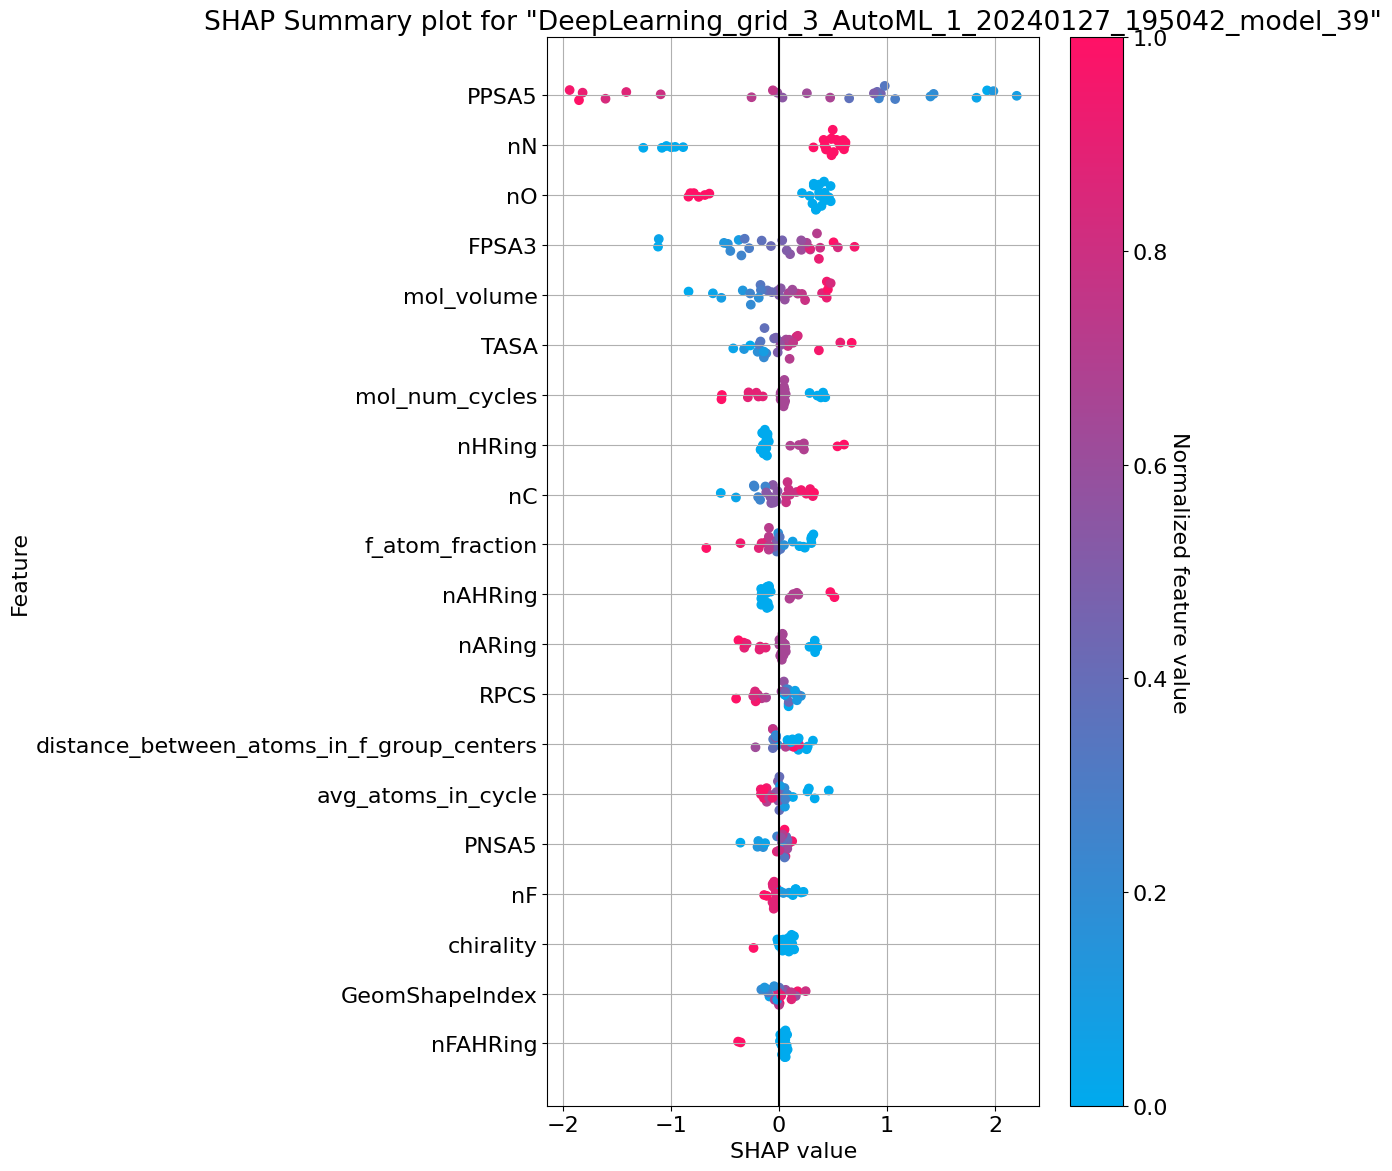

In [28]:
plt.rcParams.update({"font.size": 16})
shap_plot = test_model.shap_summary_plot(test, background_frame=train, samples=2000)

VARIABLE IMPORTANCE:

deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%


c:\work\DrugDiscovery\drug-discovery-venv\Lib\site-packages\h2o\frame.py:1979: H2ODependencyWarning: converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above).
  warnings.warn("converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
c:\work\DrugDiscovery\drug-discovery-venv\Lib\site-packages\h2o\frame.py:1979: H2ODependencyWarning: converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above).
  warnings.warn("converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


Text(0.5, 0, 'Percent')

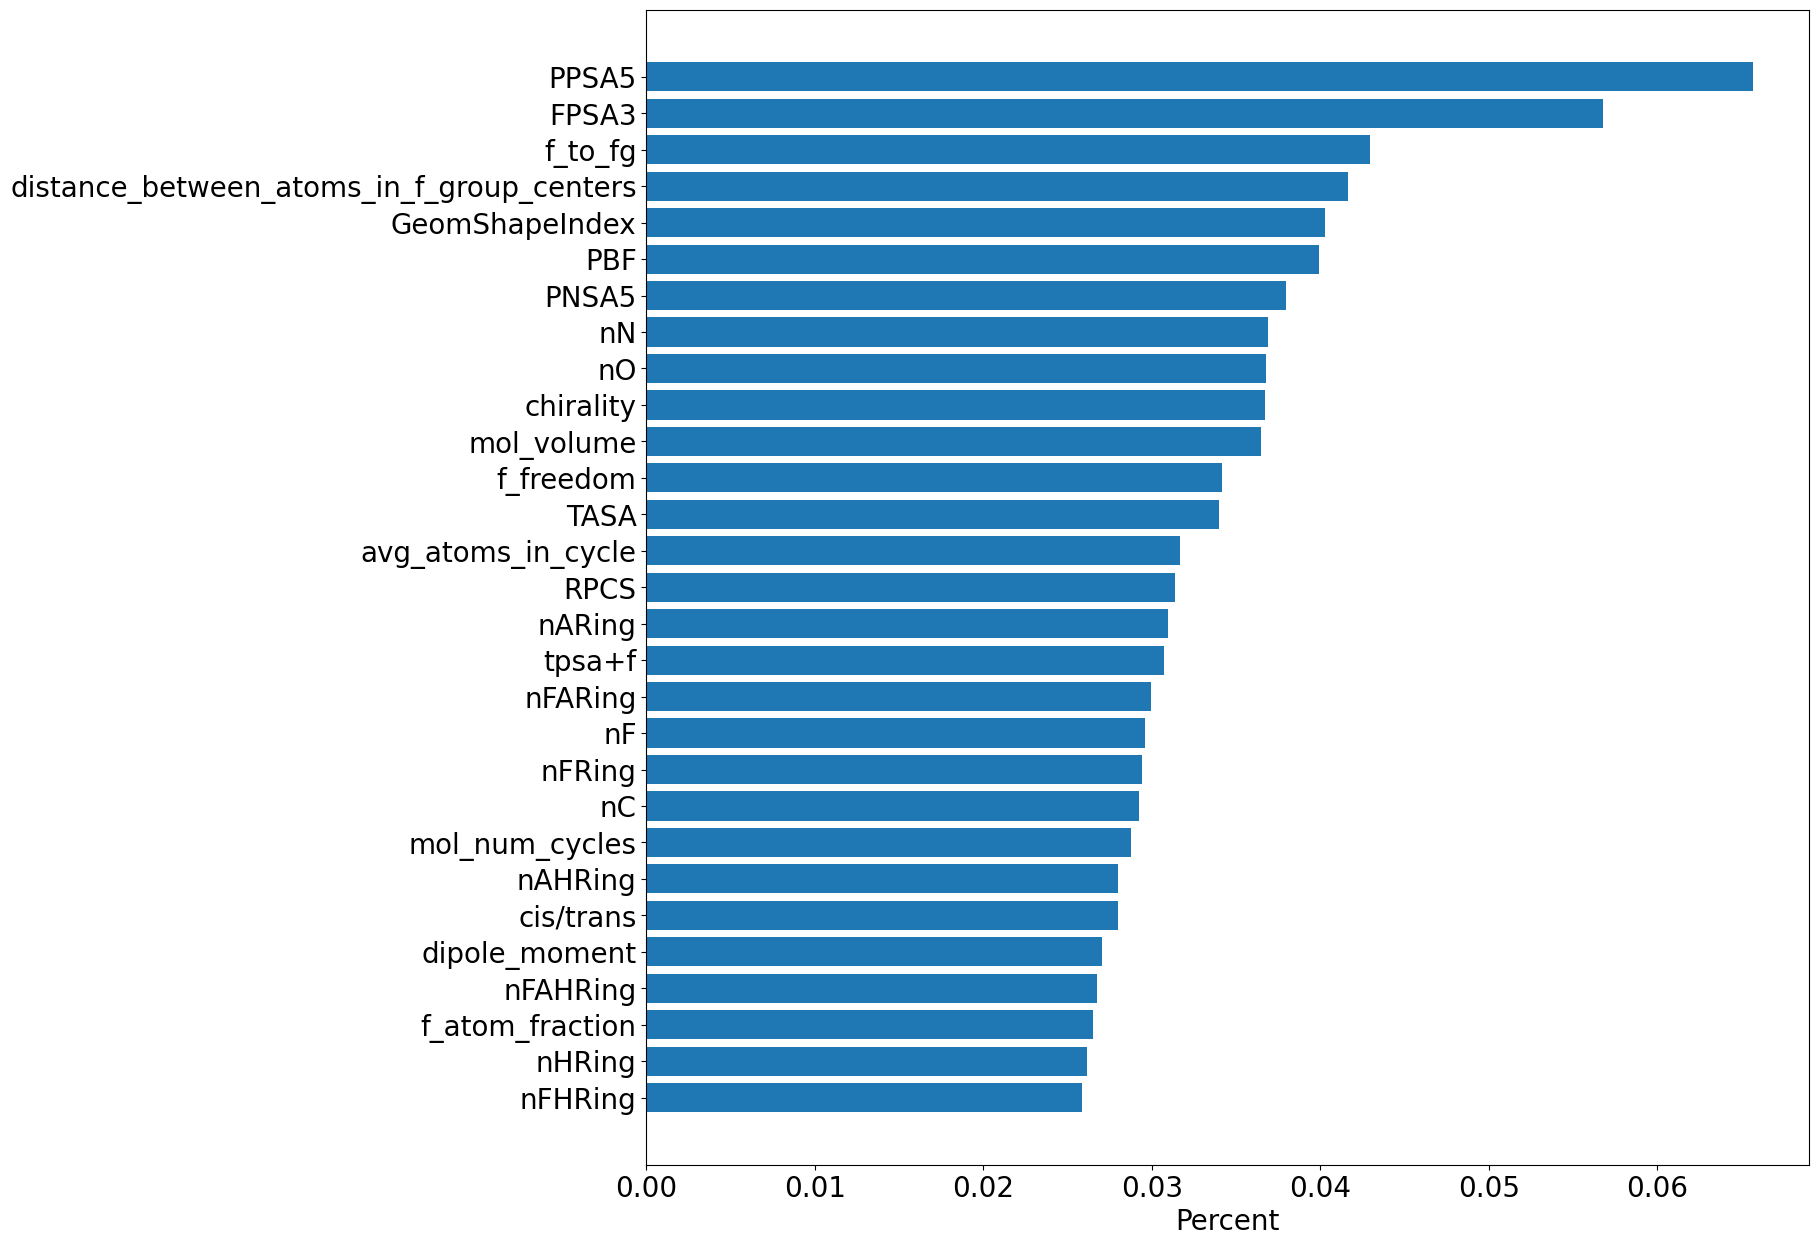

In [31]:
import matplotlib.pyplot as plt

# best_model = aml.get_best_model()
plt.rcParams.update({"font.size": 20})
preds = test_model.predict(test)
true = test.as_data_frame()['pKa']
predicted_values = preds.as_data_frame()['predict']

calculate_metrics(true, predicted_values)

importance = test_model.varimp(test)

fig, ax = plt.subplots(figsize=(15, 15))
ax.barh(importance['variable'][:][::-1], importance['percentage'][:][::-1])
ax.set_xlabel('Percent')


In [2]:
import sys
import os

sys.path.insert(0, r'C:\work\DrugDiscovery\fluoricLogPpKa')

from fluoriclogppka.ml_part.inference.inference import Inference
from fluoriclogppka.ml_part.constants import Target, Identificator

import pandas as pd
import time

excel_file_path = r'C:\work\DrugDiscovery\main_git\XAI_Chem\ml_part\molecule_features\pKa_Prediction_Starting data_2023.11.22.xlsx'
df = pd.read_excel(excel_file_path, sheet_name="Main_List")

start_time = time.time()

for index, row in df.iterrows():
    SMILES = row['Smiles']
    if pd.isnull(SMILES):
        continue
    
    print(f"SMILES: {SMILES} feature generation")
    inference = Inference(SMILES=SMILES,
                          target_value=Target.logP,
                          is_fast_mode=True)
    
    print(f"SMILES: {SMILES} logP prediction")
    predicted_logP = inference.predict()

    if index > 4:
        break

end_time = time.time()

SMILES: FC1(F)CCC(CC1)C(=O)NC1=CC=CC=C1 feature generation
SMILES: FC1(F)CCC(CC1)C(=O)NC1=CC=CC=C1 logP prediction
SMILES: O=C(NC1=CC=CC=C1)C1CCCCC1 feature generation
SMILES: O=C(NC1=CC=CC=C1)C1CCCCC1 logP prediction
SMILES: O=C(NC1=CC=CC=C1)[C@H]1C[C@@H]2C[C@@H]2C1 feature generation
SMILES: O=C(NC1=CC=CC=C1)[C@H]1C[C@@H]2C[C@@H]2C1 logP prediction
SMILES: O=C(NC1=CC=CC=C1)[C@@H]1C[C@@H]2C[C@@H]2C1 feature generation
SMILES: O=C(NC1=CC=CC=C1)[C@@H]1C[C@@H]2C[C@@H]2C1 logP prediction
SMILES: FC1(F)[C@H]2C[C@H](C[C@@H]12)C(=O)NC1=CC=CC=C1 feature generation
SMILES: FC1(F)[C@H]2C[C@H](C[C@@H]12)C(=O)NC1=CC=CC=C1 logP prediction


Accurate mode:

In [6]:
print("in miliseconds:", (end_time - start_time)*1000)

in miliseconds: 221437.0756149292


Fast mode (cofnormers):

In [4]:
print("in miliseconds:", (end_time - start_time)*1000)

in miliseconds: 192886.084318161


In [3]:
print("in miliseconds:", (end_time - start_time)*1000)

in miliseconds: 169300.52590370178


Fast mode (cofnormers + h2o init fix):

In [1]:
import sys
import os

sys.path.insert(0, r'C:\work\DrugDiscovery\fluoricLogPpKa')

from fluoriclogppka.ml_part.inference.inference import Inference
from fluoriclogppka.ml_part.constants import Target, Identificator
from fluoriclogppka.ml_part.data_preparation.smiles_to_features import Featurizer

import pandas as pd
import time

excel_file_path = r'C:\work\DrugDiscovery\main_git\XAI_Chem\ml_part\molecule_features\pKa_Prediction_Starting data_2023.11.22.xlsx'
df = pd.read_excel(excel_file_path, sheet_name="Main_List")

start_time = time.time()

features = []

for index, row in df.iterrows():
    SMILES = row['Amides for LogP']
    if pd.isnull(SMILES):
        continue
    
    print(f"SMILES: {SMILES} feature generation")
    
    dataPrep = Featurizer(SMILES=SMILES,
                          target_value=Target.logP,
                          conformers_limit=50)
    features_for_predict = dataPrep.features_for_predict
    features.append(features_for_predict)

    if index > 4:
        break

end_time = time.time()

SMILES: FC1(F)CCC(CC1)C(=O)NC1=CC=CC=C1 feature generation
SMILES: O=C(NC1=CC=CC=C1)C1CCCCC1 feature generation
SMILES: O=C(NC1=CC=CC=C1)[C@H]1C[C@@H]2C[C@@H]2C1 feature generation
SMILES: O=C(NC1=CC=CC=C1)[C@@H]1C[C@@H]2C[C@@H]2C1 feature generation
SMILES: FC1(F)[C@H]2C[C@H](C[C@@H]12)C(=O)NC1=CC=CC=C1 feature generation


In [3]:
import pandas as pd

# from fluoriclogppka.ml_part.constants import LOGP_MODEL_PATH, PKA_AMINE_MODEL_PATH, PKA_ACID_MODEL_PATH
from fluoriclogppka.ml_part.services.h2o_service import H2OService

df = pd.DataFrame(features)

LOGP_MODEL_PATH = r'C:\work\DrugDiscovery\fluoricLogPpKa\fluoriclogppka\ml_part\models_weights\h2o_models\logP\all_molecules(without_angle_feature)_without_outliers\StackedEnsemble_BestOfFamily_3_AutoML_2_20240208_214951'
model_path = LOGP_MODEL_PATH
h2oService = H2OService(model_path)

predicted_value = h2oService.predict_many(df)

In [4]:
predicted_value

predict
2.652
2.8102
2.92094
2.69791
2.62818
